# Avaliando o MNIST Dataset usando MLP do scikit-learn

## Por: 
### * Arthur Souza Cruz
### * Eduardo Fernando de Lima

Importações necessárias para avaliar o dataset.

* numpy - Para interagir com o dataset
* sklearn - Para importar o MultiLayer Perceptron
* matplotlib - Plotar gráficos
* keras - Para leitura do dataset
* tensorflow - usado como backend do keras

In [21]:
%matplotlib inline

import warnings
import random
import json
from timeit import default_timer as timer

from tqdm import trange
from IPython.display import clear_output

from keras import datasets

import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.datasets.base import get_data_home 
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)



Definindo tamanho (em porcentagem) do Dataset

In [22]:
TRANING_DATASET_SIZE = 0.8
TEST_DATASET_SIZE = 0.2

O código a seguir ignora os warnings (por conta de funções deprecated no scikit-learn que sujam a saida)

Em seguida, baixamos o dataset MNIST original que vai ser salvo na pasta home do sckit-learn

In [23]:

#Ignorando os warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Downloading MNIST data')
print(f"Downloading at: {get_data_home()}")
mnist_dataset = fetch_mldata('MNIST original')
print('Downloaded and loaded!')
    

Downloaded and loaded!


* Separando os dados dos resultados reais (targets)
* Em seguida, de forma randômica, separamos os conjuntos de teste e de treino.

In [24]:
data = mnist_dataset.data
target = mnist_dataset.target

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=TEST_DATASET_SIZE, random_state=42)

print(f"Training dataset size: {len(data_train)}")
print(f"Test dataset size: {len(data_test)}")

Training dataset size: 56000
Test dataset size: 14000


Imprime algumas imagens de exemplo do dataset

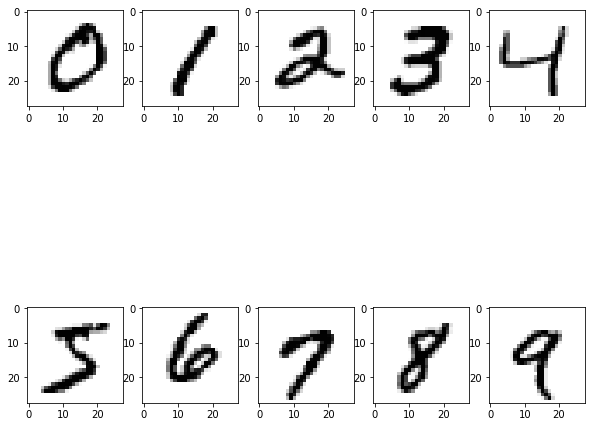

In [25]:
fig, ax = plt.subplots(2,5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(target == i)[0]
    plottable_image = np.reshape(data[im_idx], (28, 28))
    ax.imshow(plottable_image, cmap='gray_r')

Imprime a representação de um dos números do dataset

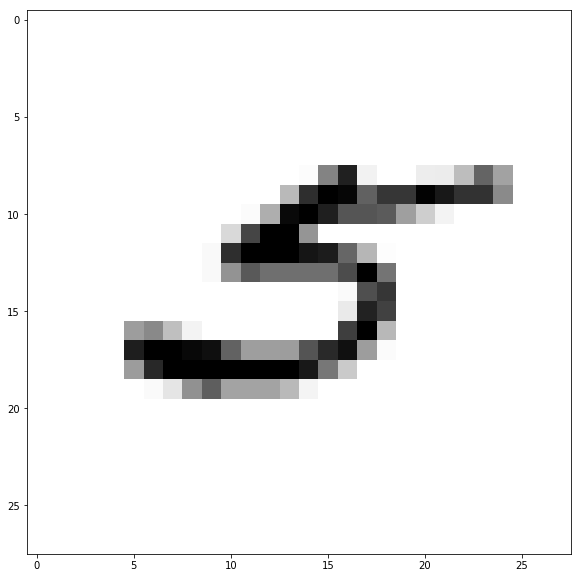

In [26]:
fig, ax = plt.subplots(1)
im_idx = 34567
plottable_image = np.reshape(data[im_idx], (28, 28))
ax.imshow(plottable_image, cmap='gray_r')

Imprime a matriz com os valores da imagem anterior

In [27]:
for index, value in enumerate(data[im_idx]):
    if index % 28 == 0: print("\n")
    print(f"{value} ", end="")



0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 124 221 13 0 0 18 19 66 154 93 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 70 208 254 248 157 200 200 251 230 203 203 117 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 4 81 244 253 223 169 169 163 96 49 12 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 38 185 254 254 106 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 6 208 254 254 254 233 226 152 73 2 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 6 107 165 143 143 143 143 178 254 138 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 175 200 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Para este estudo, gostariamos de testar para diferentes solvers e diferentes tipos de layers.

Os passos então são:
    * Para cada solver
        * Para cada hidden layer
            - Classificamos com o solver e a quantidade de hidden layers
            - Treinamos o classificador
            - Tiramos a acurácia para o conjunto de treino e teste
            - Guardamos estes dados para comparações futuramente.

**ATENÇÃO**

**ESTE TRECHO PODE DEMORAR BASTANTE PARA EXECUTAR DEVIDO AO TAMANHO DO DATASET.**

**O ARQUIVO results.json JÁ POSSUI OS RESULTADOS. RECOMENDA-SE PULAR DUAS CÉLULAS**

**CASO NÃO QUEIRA RODAR NOVOS TESTES**

In [47]:
solvers = ["lbfgs", "sgd", "adam"]
hidden_layers = [(10,10,10,10), (64,64,64,64), (128,128,128,128), (64, 128, 64, 10), (128,128), (64,64)]

datadumps = []

for solver in solvers:
    for hidden_layer in hidden_layers:
        print(len(data_train[0]))
        start = timer()
        mlp_classifier = MLPClassifier(solver = solver, hidden_layer_sizes=hidden_layer, verbose=True, max_iter=200, alpha=0.0001, tol=1e-4)
        print(f"Fitting model with solver {solver} and iterations {hidden_layer}")
        print("ok")
        mlp_classifier.fit(data_train,target_train)
        print("ok")
        print("Fitting model ended")
        end = timer()
        
        
        training_set_score = mlp_classifier.score(data_train, target_train)
        test_set_score = mlp_classifier.score(data_test, target_test)
        
        datadump = {"Solver": solver, "Hidden Layers" : hidden_layer, "Training set score": training_set_score, "Test set score" : test_set_score, "Time spent": end - start}
        datadumps.append(datadump)

file = open("results.json","w") 
file.write(json.dumps(datadumps))
file.close()




784
Fitting model with solver lbfgs and iterations (10, 10, 10, 10)
ok


KeyboardInterrupt: 

Exportamos o resultado para um json para que possa ser comparado com outros resultados em outros notebooks

In [28]:

json_data = ""

with open("./results.json", encoding='utf-8-sig') as json_file:
    text = json_file.read()
    json_data = json.loads(text)
    
print(json_data)

[{'Solver': 'lbfgs', 'Hidden Layers': [10, 10, 10, 10], 'Training set score': 0.3710535714285714, 'Test set score': 0.3737142857142857, 'Time spent': 147.8634598}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 64, 64, 64], 'Training set score': 0.9975892857142857, 'Test set score': 0.9629285714285715, 'Time spent': 258.2112311}, {'Solver': 'lbfgs', 'Hidden Layers': [128, 128, 128, 128], 'Training set score': 1.0, 'Test set score': 0.9696428571428571, 'Time spent': 397.34849610000003}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 128, 64, 10], 'Training set score': 0.5924821428571428, 'Test set score': 0.5916428571428571, 'Time spent': 272.08793319999995}, {'Solver': 'lbfgs', 'Hidden Layers': [128, 128], 'Training set score': 1.0, 'Test set score': 0.9668571428571429, 'Time spent': 280.197361}, {'Solver': 'lbfgs', 'Hidden Layers': [64, 64], 'Training set score': 0.9538928571428571, 'Test set score': 0.9405714285714286, 'Time spent': 165.88562980000006}, {'Solver': 'sgd', 'Hidden Layers': [10, 

Faz um gráfico para visualizar o score em cada solver e em cada quantidade de hidden layers. 

Também é plotado um gráfico da razão tempo/solver para cada tipo de hidden layer 

In [29]:
import matplotlib.pyplot as plt

hidden_layers = [(10,10,10,10), (64,64,64,64), (128,128,128,128), (64, 128, 64, 10), (128,128), (64,64)]

lbfgs_test_scores = []
lbfgs_training_scores = []
lbfgs_time = 0

sgd_test_scores = []
sgd_training_scores = []
sgd_time = 0

adam_test_scores = []
adam_training_scores = []
adam_time = 0

for data in json_data:
    if data["Solver"] == "lbfgs":
        lbfgs_test_scores.append(data["Test set score"] * 100)
        lbfgs_training_scores.append(data["Training set score"] * 100)
        lbfgs_time += data["Time spent"]
    elif data["Solver"] == "sgd":
        sgd_test_scores.append(data["Test set score"] * 100)
        sgd_training_scores.append(data["Training set score"] * 100)
        sgd_time += data["Time spent"]
    elif data["Solver"] == "adam":
        adam_test_scores.append(data["Test set score"] * 100)
        adam_training_scores.append(data["Training set score"] * 100)
        adam_time += data["Time spent"]
        
lbfgs_test_scores = tuple(lbfgs_test_scores)
lbfgs_training_scores = tuple(lbfgs_training_scores)

sgd_test_scores = tuple(sgd_test_scores)
sgd_training_scores = tuple(sgd_training_scores)

adam_test_scores = tuple(adam_test_scores)
adam_training_scores = tuple(adam_training_scores)
        


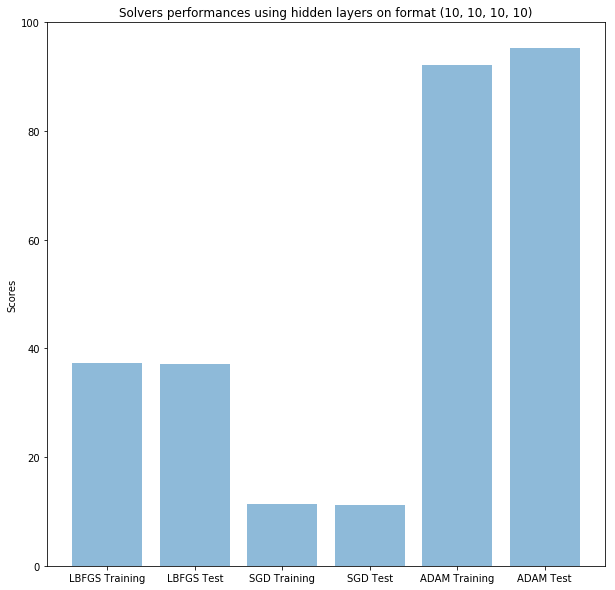

LBFGS Training: 37.371 %
LBFGS Test: 37.105 %
SGD Training: 11.293 %
SGD Test: 11.243 %
ADAM Training: 92.071 %
ADAM Test: 95.261 %


In [30]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[0])
scores.append(lbfgs_training_scores[0])
scores.append(sgd_test_scores[0])
scores.append(sgd_training_scores[0])
scores.append(adam_test_scores[0])
scores.append(adam_training_scores[0])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[0]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

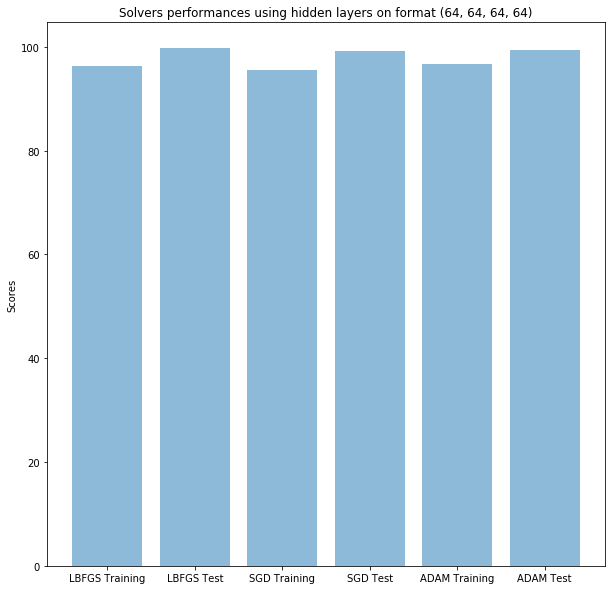

LBFGS Training: 96.293 %
LBFGS Test: 99.759 %
SGD Training: 95.550 %
SGD Test: 99.271 %
ADAM Training: 96.750 %
ADAM Test: 99.380 %


In [31]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[1])
scores.append(lbfgs_training_scores[1])
scores.append(sgd_test_scores[1])
scores.append(sgd_training_scores[1])
scores.append(adam_test_scores[1])
scores.append(adam_training_scores[1])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[1]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

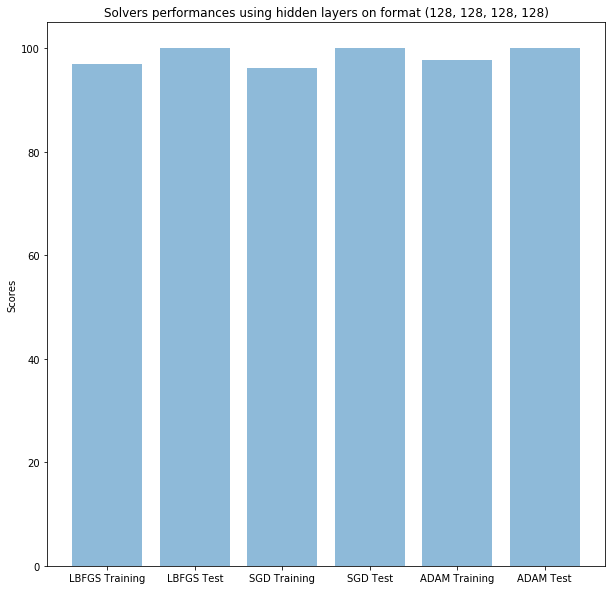

LBFGS Training: 96.964 %
LBFGS Test: 100.000 %
SGD Training: 96.221 %
SGD Test: 100.000 %
ADAM Training: 97.671 %
ADAM Test: 99.936 %


In [32]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[2])
scores.append(lbfgs_training_scores[2])
scores.append(sgd_test_scores[2])
scores.append(sgd_training_scores[2])
scores.append(adam_test_scores[2])
scores.append(adam_training_scores[2])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[2]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

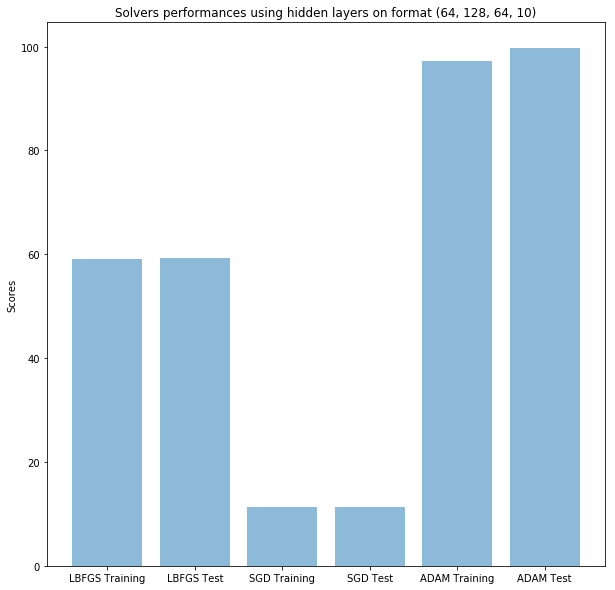

LBFGS Training: 59.164 %
LBFGS Test: 59.248 %
SGD Training: 11.293 %
SGD Test: 11.243 %
ADAM Training: 97.243 %
ADAM Test: 99.714 %


In [33]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[3])
scores.append(lbfgs_training_scores[3])
scores.append(sgd_test_scores[3])
scores.append(sgd_training_scores[3])
scores.append(adam_test_scores[3])
scores.append(adam_training_scores[3])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[3]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

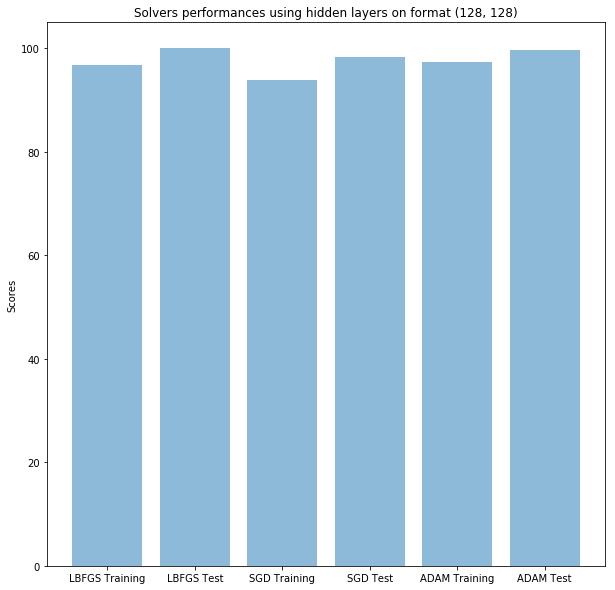

LBFGS Training: 96.686 %
LBFGS Test: 100.000 %
SGD Training: 93.929 %
SGD Test: 98.271 %
ADAM Training: 97.286 %
ADAM Test: 99.662 %


In [34]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[4])
scores.append(lbfgs_training_scores[4])
scores.append(sgd_test_scores[4])
scores.append(sgd_training_scores[4])
scores.append(adam_test_scores[4])
scores.append(adam_training_scores[4])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[4]}")

plt.show()


for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

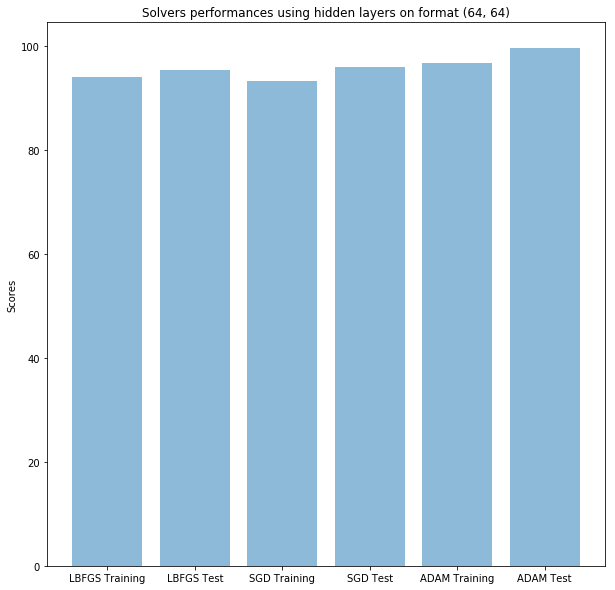

LBFGS Training: 94.057 %
LBFGS Test: 95.389 %
SGD Training: 93.214 %
SGD Test: 95.941 %
ADAM Training: 96.779 %
ADAM Test: 99.639 %


In [35]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test")

scores = []

scores.append(lbfgs_test_scores[5])
scores.append(lbfgs_training_scores[5])
scores.append(sgd_test_scores[5])
scores.append(sgd_training_scores[5])
scores.append(adam_test_scores[5])
scores.append(adam_training_scores[5])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[5]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

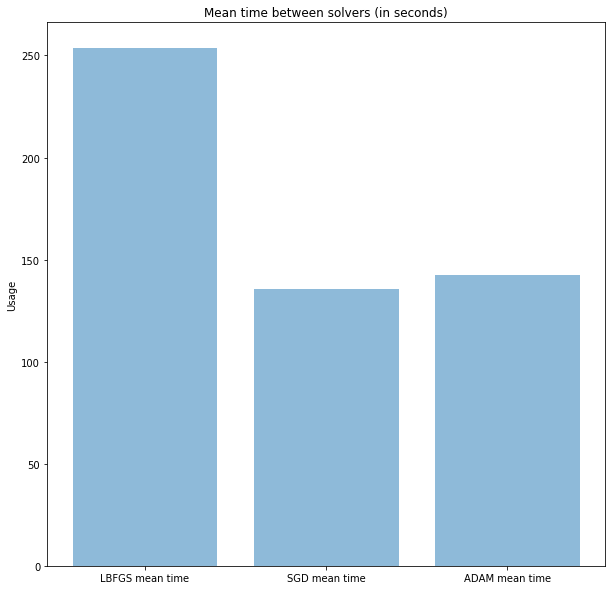

In [36]:
objects = ("LBFGS mean time", "SGD mean time", "ADAM mean time")

scores = []

mean_lbfgs_time = lbfgs_time/6
mean_sgd_time = sgd_time/6
mean_adam_time = adam_time/6

scores.append(mean_lbfgs_time)
scores.append(mean_sgd_time)
scores.append(mean_adam_time)

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title(f"Mean time between solvers (in seconds)")

plt.show()

# Resolvendo com solver próprio

# Importaões

Abaixo estão as importações necessárias para a execução do programa.

In [37]:
from __future__ import print_function
from tqdm import trange
from IPython.display import clear_output

import numpy as np ## For numerical python
import matplotlib.pyplot as plt
from keras import datasets

%matplotlib inline

## Random seed

Abaixo é fixado a semente da função random para que os resutados desta função não varie em todas as execuções.

In [38]:
np.random.seed(42)

## Parametros

Abaixo estão fixados os parâmetros da rede. Nota-se que a rede tem apenas uma camada escondida

In [39]:
# Número de perceptrons na entrada
input_layer_sizes = [128] # FIXO
# Número de perceptrons na primeira camada escondida
hidden_layer_1_sizes = [128]
# Número de perceptrons na primeira camada escondida
hidden_layer_2_sizes = [128]
# Número de perceptrons na camada de saída
output_layer_sizes = [10] # FIXO

# Taxa de aprendizado
alpha = 0.1
# Número de épocas
epochs = 25

## Classes

Abaixo estão as classes utilizadas pelo programa.

### Layer

Classe que representa uma camada genérica e "burra", ou seja , que apenas propaga o que recebe.

In [40]:
class Layer:
    
    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass


    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        # A dummy layer just returns whatever it gets as input.
        return input

      
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule

### ReLU

Classe que representa a função de ativação ReLU como uma camada e é utilizada como um "aresta" entre duas outras camadas.

In [41]:
class ReLU(Layer):
  
  
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad

### Dense

Classe que representa uma camada mais complexa com funções de aprendizado.

In [42]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units)
                                       )
        
        self.biases = np.zeros(output_units)
    
    
    def forward(self, input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input, self.weights) + self.biases
    
    
    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

## Leitura do Dataset

Abaixo está a função que lê o dataset e o divide em 3 categorias: treino, validação e teste.

In [43]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

## Exemplo

Exemplo de entrada vindo do Dataset MNIST (em formato de imagem).

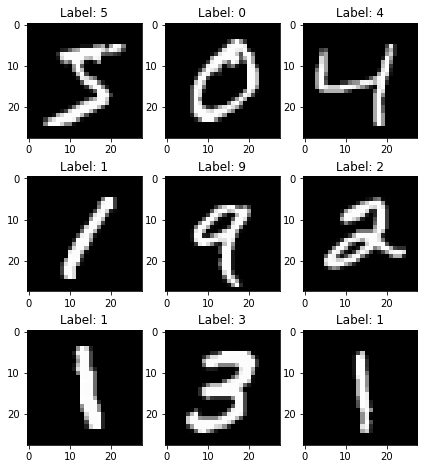

In [44]:

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize = [7, 8])
for i in range(9):
    plt.subplot(3, 3,i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap = 'gray');
    
   


## Funções Auxiliares

Abaixo estão funçoes que auxiliam o programa em sua execução, sendo as duas loss functions e a terceira para a execução do mini-batch stochastic gradient descent.

In [45]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis = -1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Funções para execução

Funções utilizadas para o treino da Rede Neural. A função forward calcula as ativações de toda a rede executando as camadas sequencialmente. A função predict prediz o resuldo

In [46]:
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    # Compute network predictions. Returning indices of largest Logit probability

    logits = forward(network, X)[-1]
    return logits.argmax(axis = -1)

def train(network, X, y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

## Execução

### Criação da rede

O código abaixo instancia a rede adicionando suas camadas em um vetor.

In [47]:
network = []
network.append(Dense(X_train.shape[1], input_layer_sizes[0], alpha))
network.append(ReLU())
network.append(Dense(input_layer_sizes[0], hidden_layer_1_sizes[0], alpha))
network.append(ReLU())
network.append(Dense(hidden_layer_1_sizes[0], hidden_layer_2_sizes[0], alpha))
network.append(ReLU())
network.append(Dense(hidden_layer_2_sizes[0], output_layer_sizes[0], alpha))


### Treino

O código abaixo executa o treino sobre o Dataset. A cada época ele também valida os resultados, utilizando o conjunto de validação, permitindo assim que seja possível observar o comportamento em relação a instâncias que não estão presentes no conjunto de treino e compará-los.

Epoch 24
Train accuracy: 0.99912
Val accuracy: 0.9787


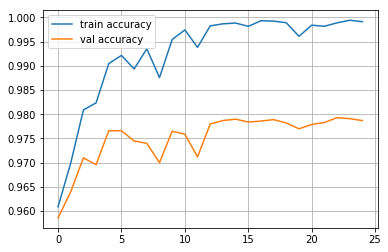

199.18925008199994


In [48]:
train_log = []
val_log = []

start = timer()
for epoch in range(epochs):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train,batchsize = 32, shuffle = True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label = 'train accuracy')
    plt.plot(val_log, label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()
end = timer()
our_total_time = end - start
print(our_total_time)

### Teste

O código abaixo faz a predição para o conjunto de testes e calcula sua acurácia.

In [49]:
test_log = []
preditions = predict(network, X_test)
out = "["

print("Expected: ")
print(y_test)

print()
print("Predicted: ")

print(preditions)

test_log.append(np.mean(predict(network, X_test) == y_test))
our_accuracy = test_log[-1] * 100

print()
print("Final accuracy on tests:", "{0:.3f}".format(our_accuracy), "%")


Expected: 
[7 2 1 ... 4 5 6]

Predicted: 
[7 2 1 ... 4 5 6]

Final accuracy on tests: 98.030 %


### Exportação

Escrita dos resultados no json

In [50]:
with open("resultados.json", "w") as json_file:
    json_file.write(json.dumps({"total_time": our_total_time, "accuracy": our_accuracy}))

# Comparação dos resultados

Neste momento, comparamos todos os solvers do scikit-learn com os solver feito por nós.

O solver feito por nós, obteve bons resultados e se comparou aos solvers do scikit-learn

Vale ressaltar que, o nosso solver utilizou duas layers escondidas com 128 neurônios cada, enquanto os testes realizados com o scikit-learn foram testados com diferentes configurações de neurônios.

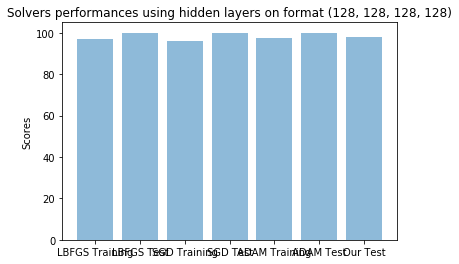

LBFGS Training: 96.964 %
LBFGS Test: 100.000 %
SGD Training: 96.221 %
SGD Test: 100.000 %
ADAM Training: 97.671 %
ADAM Test: 99.936 %
Our Test: 98.030 %


In [51]:
objects = ("LBFGS Training", "LBFGS Test" , "SGD Training", "SGD Test", "ADAM Training", "ADAM Test", "Our Test")

with open("resultados.json", "r") as json_file:
    json_data = json.loads(json_file.read())


scores = []

scores.append(lbfgs_test_scores[2])
scores.append(lbfgs_training_scores[2])
scores.append(sgd_test_scores[2])
scores.append(sgd_training_scores[2])
scores.append(adam_test_scores[2])
scores.append(adam_training_scores[2])
scores.append(json_data["accuracy"])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Scores')
plt.title(f"Solvers performances using hidden layers on format {hidden_layers[2]}")

plt.show()

for pos, obj in enumerate(objects):
    print(obj + ": " + str("{0:.3f}".format(scores[pos])) + " %")

Aqui, realizamos os testes com relação ao tempo médio dos testes.

É possível observar que o solver feito por nós conseguiu obter um tempo tão bom quanto os solvers do scikit-learn

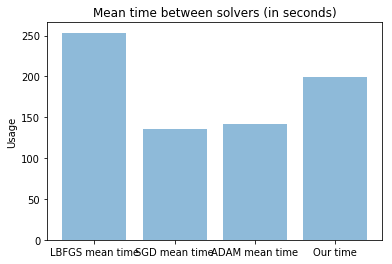

In [52]:
objects = ("LBFGS mean time", "SGD mean time", "ADAM mean time", "Our time")

with open("resultados.json", "r") as json_file:
    json_data = json.loads(json_file.read())

scores = []

mean_lbfgs_time = lbfgs_time/6
mean_sgd_time = sgd_time/6
mean_adam_time = adam_time/6

scores.append(mean_lbfgs_time)
scores.append(mean_sgd_time)
scores.append(mean_adam_time)
scores.append(json_data["total_time"])

y_pos = np.arange(len(objects))

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title(f"Mean time between solvers (in seconds)")

plt.show()